
Optimal Schedule Results:
Orders On Time: 19/50
Average Lateness: 109.02

Machine Utilization Times:
Cutting: [464, 471]
Sewing: [571, 577, 535]
Packing: 582

Lateness Distribution:
O011: 32 units late
O017: 110 units late
O015: 116 units late
O035: 19 units late
O045: 3 units late
O006: 137 units late
O007: 204 units late
O047: 193 units late
O016: 159 units late
O023: 109 units late
O025: 94 units late
O032: 163 units late
O009: 31 units late
O008: 35 units late
O010: 149 units late
O026: 88 units late
O034: 303 units late
O033: 213 units late
O042: 68 units late
O048: 98 units late
O041: 20 units late
O027: 330 units late
O037: 353 units late
O001: 126 units late
O021: 97 units late
O003: 360 units late
O012: 197 units late
O002: 340 units late
O019: 450 units late
O030: 384 units late
O046: 470 units late


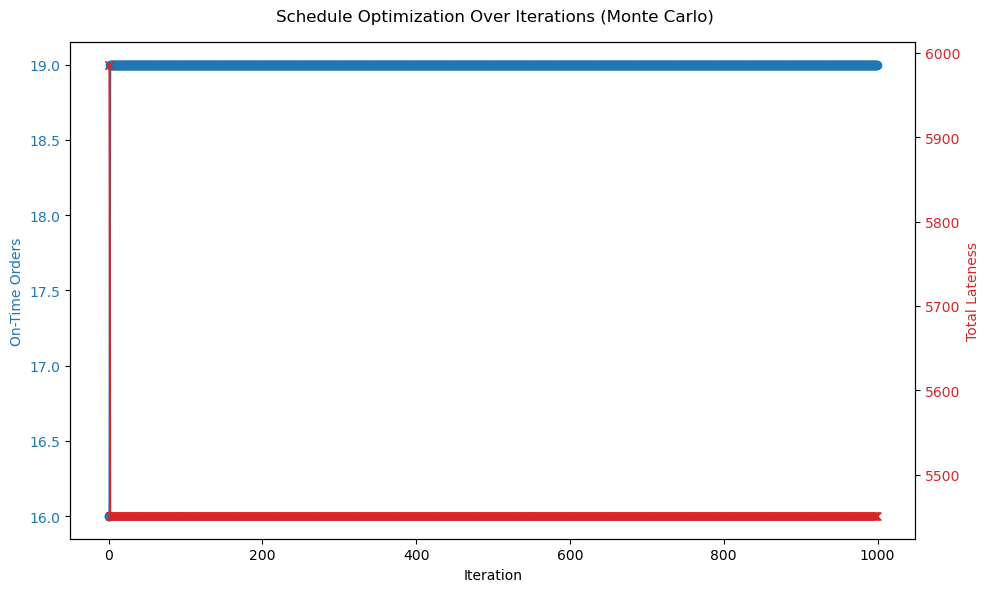

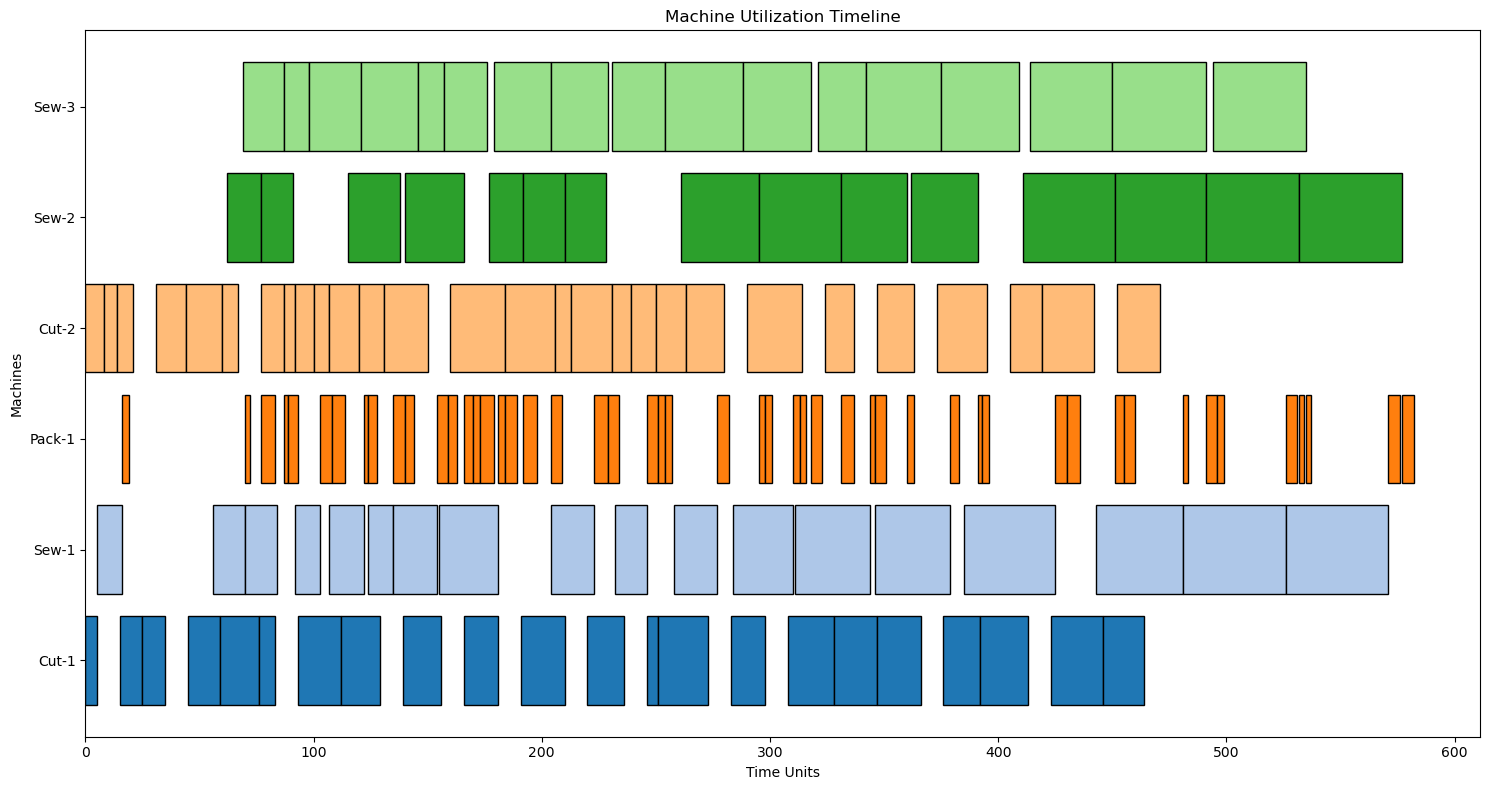

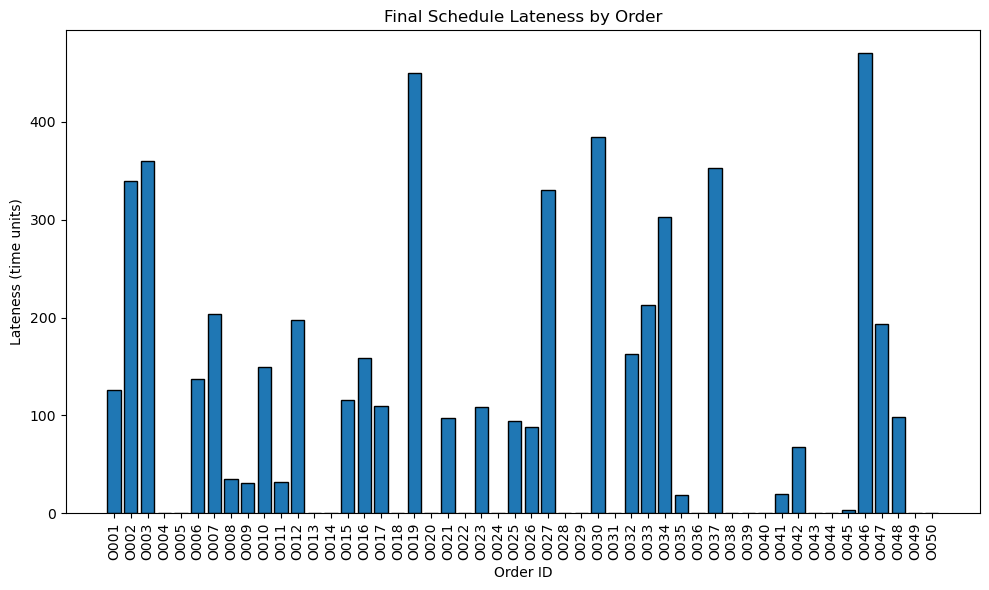

In [5]:
import pandas as pd
import random
import matplotlib.pyplot as plt

# ====================
# Data Loading & Classes
# ====================

class Order:
    def __init__(self, row):
        self.order_id = row['order_id']
        self.product_type = row['Product type']
        self.cut_time = row['cut time']
        self.sew_time = row['sew time']
        self.pack_time = row['pack time']
        self.deadline = row['deadline']
        self.requires_delay = row['requires_out_of_factory_delay']


class Machine:
    def __init__(self, machine_type, machine_id):
        self.machine_id = f"{machine_type}-{machine_id}"
        self.available_at = 0
        self.last_product = None
        self.utilization = []


def load_data(csv_path):
    """
    Reads the CSV, converts the 'requires_out_of_factory_delay' column to booleans,
    and returns the DataFrame.
    """
    df = pd.read_csv(csv_path)

    # Convert text TRUE/FALSE into boolean
    df['requires_out_of_factory_delay'] = (
        df['requires_out_of_factory_delay']
        .astype(str)
        .str.upper()
        .map({'TRUE': True, 'FALSE': False})
    )
    return df


# ====================
# Scheduling Core
# ====================

def simulate_schedule(orders):
    """
    Simulates the scheduling of a given order sequence from
    cut -> (optional delay) -> sew -> pack.

    Returns:
        - schedule (dict): For each order, a dict of {'Cut', 'Sew', 'Pack', 'Lateness'} details
        - lateness_summary (dict): lateness by order_id
        - total_lateness (int): sum of all orders' lateness
        - on_time_count (int): how many orders are on time (lateness = 0)
        - cut_times (list): final available_at for each cutting machine
        - sew_times (list): final available_at for each sewing machine
        - pack_time (int): final available_at for the packing machine
    """
    # Create machines
    cutting_machines = [Machine('Cut', i + 1) for i in range(2)]
    sewing_machines = [Machine('Sew', i + 1) for i in range(3)]
    packing_machine = Machine('Pack', 1)

    # Tracking structures
    schedule = {}
    lateness_summary = {}
    total_lateness = 0
    on_time_count = 0

    for order in orders:
        # -------------------------------------
        # Cutting Stage
        # -------------------------------------
        cut_options = []
        for machine in cutting_machines:
            # 10 units setup if product type changes
            setup = 10 if (machine.last_product and machine.last_product != order.product_type) else 0
            start_time = machine.available_at + setup
            cut_options.append((start_time, machine))

        # Pick the earliest start time among cutting machines
        start_cut, best_cut_machine = min(cut_options, key=lambda x: x[0])
        end_cut = start_cut + order.cut_time

        # Update the chosen machine
        best_cut_machine.available_at = end_cut
        best_cut_machine.last_product = order.product_type
        best_cut_machine.utilization.append((start_cut, end_cut))

        # -------------------------------------
        # Post-Cutting Delay (48 units if needed)
        # -------------------------------------
        sew_ready_time = end_cut + (48 if order.requires_delay else 0)

        # -------------------------------------
        # Sewing Stage
        # -------------------------------------
        sew_options = []
        for machine in sewing_machines:
            start_time = max(machine.available_at, sew_ready_time)
            sew_options.append((start_time, machine))

        start_sew, best_sew_machine = min(sew_options, key=lambda x: x[0])
        end_sew = start_sew + order.sew_time

        best_sew_machine.available_at = end_sew
        best_sew_machine.utilization.append((start_sew, end_sew))

        # -------------------------------------
        # Packing Stage
        # -------------------------------------
        start_pack = max(packing_machine.available_at, end_sew)
        end_pack = start_pack + order.pack_time

        # Quick sanity check
        if start_pack < packing_machine.available_at:
            raise ValueError(f"Packing conflict in order {order.order_id}")

        packing_machine.available_at = end_pack
        packing_machine.utilization.append((start_pack, end_pack))

        # -------------------------------------
        # Lateness
        # -------------------------------------
        lateness = max(0, end_pack - order.deadline)
        total_lateness += lateness
        if lateness == 0:
            on_time_count += 1

        schedule[order.order_id] = {
            'Cut': (best_cut_machine.machine_id, start_cut, end_cut),
            'Sew': (best_sew_machine.machine_id, start_sew, end_sew),
            'Pack': (packing_machine.machine_id, start_pack, end_pack),
            'Lateness': lateness
        }
        lateness_summary[order.order_id] = lateness

    # Return all metrics
    return (
        schedule,
        lateness_summary,
        total_lateness,
        on_time_count,
        [m.available_at for m in cutting_machines],
        [m.available_at for m in sewing_machines],
        packing_machine.available_at
    )


# ====================
# Permutation Generator
# ====================

def generate_permutation(orders):
    """
    Randomly picks one of three heuristics to reorder the orders:
      1) By product_type
      2) By deadline
      3) By total processing time (cut + sew + pack)
    """
    r = random.random()
    if r < 0.5:
        # Sort by product type
        return sorted(orders, key=lambda x: x.product_type)
    elif r < 0.75:
        # Sort by earliest deadline
        return sorted(orders, key=lambda x: x.deadline)
    else:
        # Sort by total processing time
        return sorted(orders, key=lambda x: x.cut_time + x.sew_time + x.pack_time)


# ====================
# Optimization Engine
# ====================

def optimize_schedules(data, iterations=500):
    """
    Runs multiple random permutations of the orders (Monte Carlo approach),
    tracking the best schedule found based on:
      1) Highest on_time_count
      2) Lowest total_lateness (as a tiebreaker)

    Returns:
      best (dict) with best schedule details
      on_time_history (list) with the best on-time count at each iteration
      total_lateness_history (list) with the best total lateness at each iteration
    """
    orders = [Order(row) for _, row in data.iterrows()]
    
    # Dictionary to store the best schedule found
    best = {
        'on_time': -1,
        'lateness': float('inf'),
        'schedule': None,
        'cut_util': [],
        'sew_util': [],
        'pack_util': 0,
        'lateness_map': {}
    }
    
    # Lists to track performance over iterations
    on_time_history = []
    total_lateness_history = []

    for i in range(iterations):
        # Create a permutation using one of the heuristics
        permuted = generate_permutation(orders.copy())

        # Simulate the schedule
        try:
            schedule, lateness_map, total_lat, on_time, cut_util, sew_util, pack_util = simulate_schedule(permuted)
        except ValueError:
            # If there's a conflict, just record the current best
            on_time_history.append(best['on_time'])
            total_lateness_history.append(best['lateness'])
            continue

        # Compare with the best so far
        if (on_time > best['on_time']) or (on_time == best['on_time'] and total_lat < best['lateness']):
            best.update({
                'on_time': on_time,
                'lateness': total_lat,
                'schedule': schedule,
                'cut_util': cut_util,
                'sew_util': sew_util,
                'pack_util': pack_util,
                'lateness_map': lateness_map
            })

        # Record the best so far (not necessarily this iteration's schedule)
        on_time_history.append(best['on_time'])
        total_lateness_history.append(best['lateness'])

    return best, on_time_history, total_lateness_history


# ====================
# Visualization Utilities
# ====================

def plot_iteration_performance(on_time_history, total_lateness_history):
    """
    Plots how the best schedule's on-time count and total lateness
    evolve over the Monte Carlo iterations.
    """
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot On-Time Orders on left y-axis
    color1 = 'tab:blue'
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('On-Time Orders', color=color1)
    ax1.plot(range(len(on_time_history)), on_time_history, marker='o', color=color1, label='On-Time Orders')
    ax1.tick_params(axis='y', labelcolor=color1)

    # Second y-axis for Total Lateness
    ax2 = ax1.twinx()
    color2 = 'tab:red'
    ax2.set_ylabel('Total Lateness', color=color2)
    ax2.plot(range(len(total_lateness_history)), total_lateness_history, marker='x', color=color2, label='Total Lateness')
    ax2.tick_params(axis='y', labelcolor=color2)

    fig.suptitle('Schedule Optimization Over Iterations (Monte Carlo)')
    fig.tight_layout()
    plt.show()


def plot_utilization(schedule):
    """
    Gantt-like chart of machine usage.

    schedule: dict from order_id -> 
       { 'Cut': (machine_id, start, end), 'Sew': (machine_id, start, end), 'Pack': ... }
    """
    fig, ax = plt.subplots(figsize=(15, 8))
    colors = plt.cm.tab20.colors
    machine_map = {}

    # Collect machine timelines
    for order_data in schedule.values():
        for stage in ['Cut', 'Sew', 'Pack']:
            machine_id, start, end = order_data[stage]
            if machine_id not in machine_map:
                machine_map[machine_id] = []
            machine_map[machine_id].append((start, end))

    # Plot each machine's timeline as horizontal bars
    for idx, (machine_id, periods) in enumerate(machine_map.items()):
        for start, end in periods:
            ax.barh(y=idx, width=(end - start), left=start,
                    color=colors[idx % 20], edgecolor='black')

    ax.set_yticks(range(len(machine_map)))
    ax.set_yticklabels(machine_map.keys())
    ax.set_xlabel('Time Units')
    ax.set_ylabel('Machines')
    ax.set_title('Machine Utilization Timeline')
    plt.tight_layout()
    plt.show()


def plot_lateness_distribution(lateness_map):
    """
    Bar chart showing how late each order ended up in the best schedule.
    """
    # Sort by order ID (or by lateness if you prefer)
    sorted_lateness = sorted(lateness_map.items(), key=lambda x: x[0])
    order_ids = [x[0] for x in sorted_lateness]
    lateness_vals = [x[1] for x in sorted_lateness]

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(order_ids, lateness_vals, edgecolor='black')
    ax.set_xlabel('Order ID')
    ax.set_ylabel('Lateness (time units)')
    ax.set_title('Final Schedule Lateness by Order')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


# ====================
# Main Execution
# ====================
if __name__ == "__main__":
    # Update this path to your local CSV file path
    DATA_PATH = "/Users/syedakash/Desktop/Data for technical assessment - Sheet1.csv"
    orders_df = load_data(DATA_PATH)

    # Run the Monte Carlo simulation
    best_result, on_time_history, total_lateness_history = optimize_schedules(orders_df, iterations=1000)

    # Print final results
    print("\nOptimal Schedule Results:")
    print(f"Orders On Time: {best_result['on_time']}/{len(orders_df)}")
    if len(orders_df) > 0:
        avg_lateness = best_result['lateness'] / len(orders_df)
    else:
        avg_lateness = 0
    print(f"Average Lateness: {avg_lateness:.2f}")

    print("\nMachine Utilization Times:")
    print(f"Cutting: {best_result['cut_util']}")
    print(f"Sewing: {best_result['sew_util']}")
    print(f"Packing: {best_result['pack_util']}")

    print("\nLateness Distribution:")
    for order_id, lateness in best_result['lateness_map'].items():
        if lateness > 0:
            print(f"{order_id}: {lateness} units late")

    # ============================
    # 1) Plot iteration performance (Monte Carlo)
    # ============================
    plot_iteration_performance(on_time_history, total_lateness_history)

    # ============================
    # 2) Plot Gantt chart (machine utilization)
    # ============================
    plot_utilization(best_result['schedule'])

    # ============================
    # 3) Plot lateness distribution as a bar chart
    # ============================
    plot_lateness_distribution(best_result['lateness_map'])
